In [33]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime 
from pandas import json_normalize
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from collections import Counter

pd.options.display.max_rows = 999

# Insert your own client ID here
client_id = '68e4dc04-3f18-4f9f-8a0a-9c793d40bd79'

In [3]:
def findstation(ids=None,name=None,country=None,municipality=None,validtime=None,polygon=None,nearpoint=None):
    dflocal=pd.DataFrame([locals()])
    selec=''
    for col in dflocal.columns:
        if dflocal[col][0] != None:
            if col == 'nearpoint':
                selec+='&geometry=nearest(POINT('+str(dflocal[col][0])+'))'
            elif col == 'polygon':
                selec+='&geometry=POLYGON(('+str(dflocal[col][0])+'))'
            else:
                selec+='&'+str(col)+'='+str(dflocal[col][0])
    endpoint='https://frost.met.no/sources/v0.jsonld?types=SensorSystem'+selec
    print(endpoint,'\n')
    r = requests.get(endpoint, auth=(client_id,''))
    # Extract JSON data
    json = r.json()

    # Check if the request worked, print out any errors
    if r.status_code == 200:
        data = json['data']
        print('Data retrieved from frost.met.no!\n')
    else:
        print('Error! Returned status code %s' % r.status_code)
        print('Message: %s' % json['error']['message'])
        print('Reason: %s' % json['error']['reason'])
    return json_normalize(data)

In [20]:
def sourceinfo(source,filt=''):
    endpoint = 'https://frost.met.no/observations/availableTimeSeries/v0.jsonld?sources='+ source
    r = requests.get(endpoint, auth=(client_id,''))
    # Extract JSON data
    json = r.json()
    # Check if the request worked, print out any errors
    row=[]
    row2=[]
    row3=[]
    elements=pd.DataFrame()
    if r.status_code == 200:
        data = json['data']
        print('Data retrieved from frost.met.no!\n')
        for i in range(len(data)):
            # if filt in data[i]['elementId']:
            row.append(data[i]['elementId'])
            row2.append(data[i]['validFrom'])
            try:
                row3.append(data[i]['validTo'])
            except:
                row3.append(np.nan)
        elements['elementId']=row
        elements['validFrom']=row2
        elements['validTo']=row3
    else:
        print('Error! Returned status code %s' % r.status_code)
        print('Message: %s' % json['error']['message'])
        print('Reason: %s' % json['error']['reason'])
    return elements

In [5]:
def graphelement(source,elements,referencetime,rollingmean=1):

    # Define endpoint and parameters
    endpoint = 'https://frost.met.no/observations/v0.jsonld'
    parameters = {
        'sources': source,
        'elements': elements,
        'referencetime': referencetime,
    }
    # Issue an HTTP GET request
    r = requests.get(endpoint, parameters, auth=(client_id,''))
    # Extract JSON data
    json = r.json()

    # Check if the request worked, print out any errors
    if r.status_code == 200:
        data = json['data']
        print('Data retrieved from frost.met.no!')
    else:
        print('Error! Returned status code %s' % r.status_code)
        print('Message: %s' % json['error']['message'])
        print('Reason: %s' % json['error']['reason'])

    df = pd.DataFrame()
    for i in range(len(data)):
        row = pd.DataFrame(data[i]['observations'])
        row['referenceTime'] = data[i]['referenceTime']
        row['sourceId'] = data[i]['sourceId']
        df = df.append(row)

    df = df.reset_index()[['referenceTime','value']]
    df['referenceTime'] = [datetime.strptime(each, '%Y-%m-%dT%H:%M:%S.%fZ') for each in df['referenceTime']]
    df['value']=df['value'].rolling(rollingmean).mean()

    # plt.figure(figsize=(30,10))
    # ax = sns.lineplot(x="referenceTime", y="value", data=df)

    return df 

In [10]:
allids = findstation(country='Norge').id.values

https://frost.met.no/sources/v0.jsonld?types=SensorSystem&country=Norge 

Data retrieved from frost.met.no!



In [12]:
findstation(country='Norge')

https://frost.met.no/sources/v0.jsonld?types=SensorSystem&country=Norge 

Data retrieved from frost.met.no!



,@type,id,name,shortName,country,countryCode,masl,validFrom,county,countyId,...,municipalityId,stationHolders,externalIds,wigosId,geometry.@type,geometry.coordinates,geometry.nearest,wmoId,icaoCodes,shipCodes
0,SensorSystem,SN47230,ÅKRA UNGDOMSSKOLE,Åkra,Norge,NO,18.0,2013-10-29T00:00:00.000Z,ROGALAND,11.0,...,1149.0,[KARMØY KOMMUNE],[506131077],0-578-0-47230,Point,"[5.1963, 59.2555]",False,NaN,NaN,NaN
1,SensorSystem,SN23670,E16 RYFOSS,E16 Ryfoss,Norge,NO,406.0,2018-01-23T00:00:00.000Z,INNLANDET,34.0,...,3454.0,[STATENS VEGVESEN],"[1755, 3000021]",0-578-0-23670,Point,"[8.8175, 61.1375]",False,NaN,NaN,NaN
2,SensorSystem,SN59450,STADLANDET,Stadlandet,Norge,NO,75.0,1923-01-01T00:00:00.000Z,VESTLAND,46.0,...,4649.0,[MET.NO],[10.249.1.80],0-578-0-59450,Point,"[5.2115, 62.1467]",False,NaN,NaN,NaN
3,SensorSystem,SN80130,LURØY,NaN,Norge,NO,10.0,1500-01-01T00:00:00.000Z,NORDLAND,18.0,...,1834.0,[],NaN,NaN,Point,"[12.6, 66.4]",False,NaN,NaN,NaN
4,SensorSystem,SN12590,E6 MJØSBRUA,E6 Mjøsbrua,Norge,NO,128.0,2011-01-01T00:00:00.000Z,INNLANDET,34.0,...,3411.0,[STATENS VEGVESEN],"[149, 429003]",0-578-0-12590,Point,"[10.6725, 60.928]",False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591,SensorSystem,SN74780,NAMSVATN II,Namsvatn,Norge,NO,460.0,2019-09-01T00:00:00.000Z,TRØNDELAG,50.0,...,5043.0,[NVE],[139.4],0-578-0-74780,Point,"[13.5403, 64.9608]",False,NaN,NaN,NaN
1592,SensorSystem,SN94805,E69 VEDBOTN,E69 Vedbotn,Norge,NO,10.0,2013-07-22T00:00:00.000Z,TROMS OG FINNMARK,54.0,...,5435.0,[STATENS VEGVESEN],"[2000062, 271]",0-578-0-94805,Point,"[25.6297, 70.7765]",False,NaN,NaN,NaN
1593,SensorSystem,SN87430,BJARKØY,NaN,Norge,NO,30.0,1500-01-01T00:00:00.000Z,TROMS OG FINNMARK,54.0,...,5402.0,[],NaN,NaN,Point,"[16.55, 69]",False,NaN,NaN,NaN
1594,SensorSystem,SN49040,JONDAL,NaN,Norge,NO,10.0,1500-01-01T00:00:00.000Z,VESTLAND,46.0,...,4618.0,[],NaN,NaN,Point,"[6.25, 60.28]",False,NaN,NaN,NaN


In [28]:
findstation(municipality='Sogndal')

https://frost.met.no/sources/v0.jsonld?types=SensorSystem&municipality=Sogndal 

Data retrieved from frost.met.no!



,@type,id,name,country,countryCode,masl,validFrom,county,countyId,municipality,municipalityId,stationHolders,externalIds,wigosId,geometry.@type,geometry.coordinates,geometry.nearest,shortName,wmoId,icaoCodes
0,SensorSystem,SN55735,RV5 FRUDALEN,Norge,NO,521,2004-12-24T00:00:00.000Z,VESTLAND,46,SOGNDAL,4640,[STATENS VEGVESEN],"[127, 1429004]",0-578-0-55735,Point,"[6.8745, 61.3473]",False,NaN,NaN,NaN
1,SensorSystem,SN55720,SKARDSBØFJELLET,Norge,NO,713,2019-09-19T00:00:00.000Z,VESTLAND,46,SOGNDAL,4640,[STATNETT],NaN,NaN,Point,"[7.0183, 61.2168]",False,Skardsbøfjellet,NaN,NaN
2,SensorSystem,SN55705,RV5 KAUPANGER,Norge,NO,170,2011-01-01T00:00:00.000Z,VESTLAND,46,SOGNDAL,4640,[STATENS VEGVESEN],"[120, 1429034]",0-578-0-55705,Point,"[7.2098, 61.2017]",False,NaN,NaN,NaN
3,SensorSystem,SN55740,ANESTØLEN,Norge,NO,443,2019-09-01T00:00:00.000Z,VESTLAND,46,SOGNDAL,4640,[NVE],[77.24],NaN,Point,"[6.9077, 61.3648]",False,Anestølen,NaN,NaN
4,SensorSystem,SN55770,NJØS,Norge,NO,45,2005-01-01T00:00:00.000Z,VESTLAND,46,SOGNDAL,4640,[NIBIO],[7],0-578-0-55770,Point,"[6.8608, 61.1792]",False,Njøs,NaN,NaN
5,SensorSystem,SN55710,SOGNDALSFJØRA,Norge,NO,10,1500-01-01T00:00:00.000Z,VESTLAND,46,SOGNDAL,4640,[],NaN,NaN,Point,"[7.1, 61.23]",False,NaN,NaN,NaN
6,SensorSystem,SN55820,FJÆRLAND - BREMUSEET,Norge,NO,3,2005-11-20T00:00:00.000Z,VESTLAND,46,SOGNDAL,4640,[MET.NO],"[01332, 10.249.1.70]",0-20000-0-01332,Point,"[6.7642, 61.4233]",False,Fjærland,1332.0,NaN
7,SensorSystem,SN55910,BALESTRAND,Norge,NO,20,1500-01-01T00:00:00.000Z,VESTLAND,46,SOGNDAL,4640,[],NaN,NaN,Point,"[6.53, 61.2]",False,NaN,NaN,NaN
8,SensorSystem,SN55928,BALESTRAND - BALE,Norge,NO,15,2005-01-01T00:00:00.000Z,VESTLAND,46,SOGNDAL,4640,[NIBIO],[77],0-578-0-55928,Point,"[6.5285, 61.2028]",False,Balestrand,NaN,NaN
9,SensorSystem,SN55700,SOGNDAL LUFTHAMN,Norge,NO,497,1971-06-01T00:00:00.000Z,VESTLAND,46,SOGNDAL,4640,[AVINOR],"[01347, 10.249.0.61, ENSG]",0-20000-0-01347,Point,"[7.1413, 61.158]",False,Sogndal LH,1347.0,[ENSG]


In [40]:
sourceinfo(source='SN66720',filt='')

Error! Returned status code 404
Message: Not found
Reason: No data found


""


In [41]:
allelements = []
for each in allids:
    print(each)
    try:
        df = sourceinfo(source=each)
        allelements.append(pd.unique(df.elementId))
    except:
        pass
allelements = [item for each in allelements for item in each]
count_elements = Counter(allelements).most_common()

a retrieved from frost.met.no!

SN88630
Data retrieved from frost.met.no!

SN11060
Data retrieved from frost.met.no!

SN49800
Data retrieved from frost.met.no!

SN3030
Data retrieved from frost.met.no!

SN50240
Data retrieved from frost.met.no!

SN30340
Data retrieved from frost.met.no!

SN44390
Data retrieved from frost.met.no!

SN62890
Data retrieved from frost.met.no!

SN37760
Data retrieved from frost.met.no!

SN27460
Data retrieved from frost.met.no!

SN84970
Data retrieved from frost.met.no!

SN9400
Data retrieved from frost.met.no!

SN36710
Data retrieved from frost.met.no!

SN55928
Data retrieved from frost.met.no!

SN59660
Data retrieved from frost.met.no!

SN50105
Data retrieved from frost.met.no!

SN3990
Data retrieved from frost.met.no!

SN80340
Data retrieved from frost.met.no!

SN60010
Data retrieved from frost.met.no!

SN24670
Data retrieved from frost.met.no!

SN44480
Data retrieved from frost.met.no!

SN56780
Data retrieved from frost.met.no!

SN45350
Data retrieved fr

In [46]:
# pd.DataFrame(count_elements).to_csv('count_elements.csv')
count_elements

[('air_temperature', 943),
 ('integral_of_excess(mean(air_temperature P1D) P1D 5.0)', 941),
 ('integral_of_deficit(mean(air_temperature PT1H) P1D 17.0)', 941),
 ('integral_of_excess(mean(air_temperature P1D) P1D 0.0)', 940),
 ('mean(air_temperature P1D)', 940),
 ('dew_point_temperature', 816),
 ('mean(relative_humidity P1D)', 811),
 ('mean(dew_point_temperature P1D)', 745),
 ('sum(precipitation_amount P1D)', 741),
 ('max(sum(precipitation_amount P1D) P1M)', 727),
 ('sum(precipitation_amount P1M)', 726),
 ('over_time(sum(time_of_maximum_precipitation_amount P1D) P1M)', 724),
 ('number_of_days_gte(sum(precipitation_amount P1D) P1M 1.0)', 723),
 ('sum(precipitation_amount PT1H)', 710),
 ('wind_speed', 689),
 ('sum(precipitation_amount P30D)', 679),
 ('best_estimate_sum(precipitation_amount P3M)', 674),
 ('best_estimate_sum(precipitation_amount P6M)', 674),
 ('best_estimate_sum(precipitation_amount P1Y)', 674),
 ('best_estimate_sum(precipitation_amount P1M)', 674),
 ('wind_from_direction',

Data retrieved from frost.met.no!


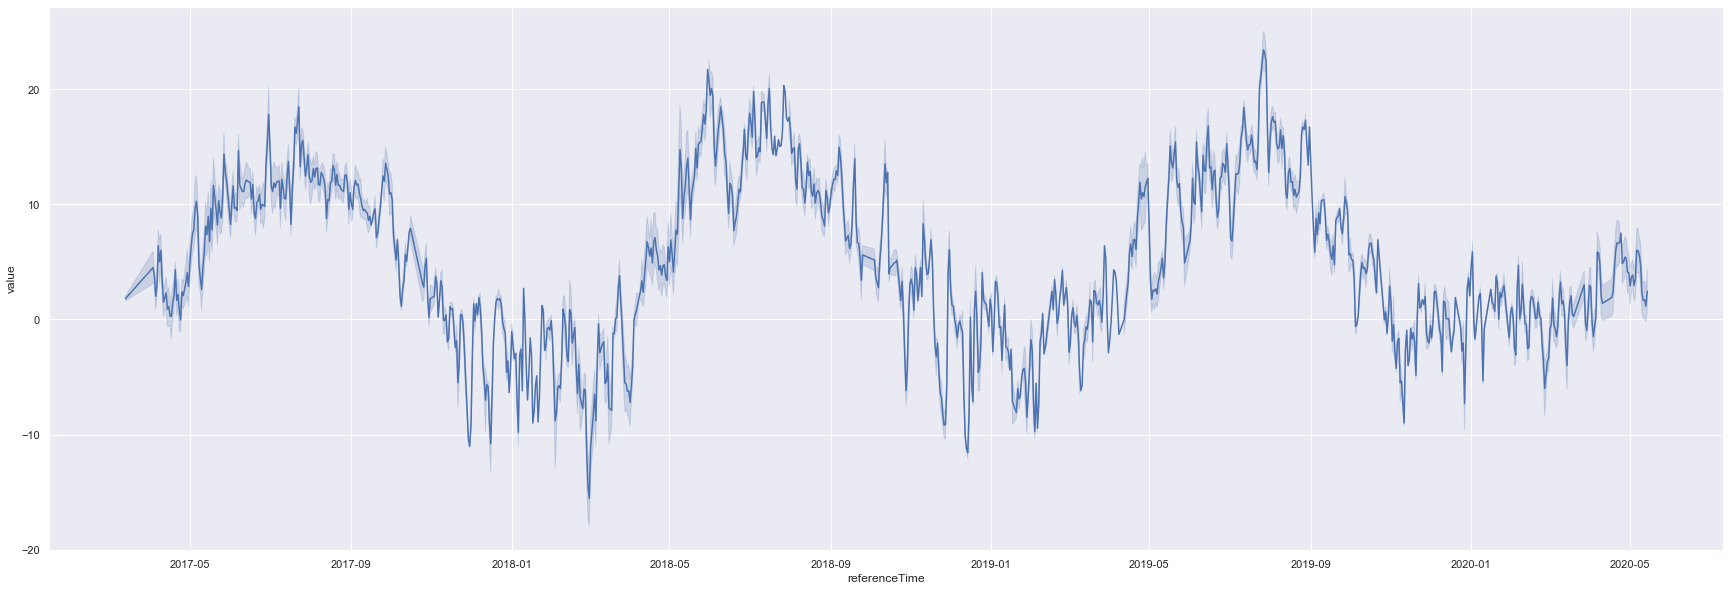

In [8]:
graphelement(source='SN55705,SN55735', elements= 'mean(air_temperature P1D)',referencetime= '2017-01-01/2020-05-15',rollingmean=1)

In [551]:
# Define endpoint and parameters
endpoint = 'https://frost.met.no/sources/v0.jsonld?types=SensorSystem&country=*&municipality=Lillest*'
# endpoint = 'https://frost.met.no/sources/v0.jsonld?types=SensorSystem&municipality=Lillest*'
# endpoint = 'https://frost.met.no/sources/v0.jsonld?ids=SN4260&types=SensorSystem'
# endpoint = 'https://frost.met.no/sources/v0.jsonld?types=SensorSystem&geometry=POLYGON ((11.3 60.03,10.99 59.95, 11.51 59.88, 11.3 60.03))'
# endpoint = 'https://frost.met.no/sources/v0.jsonld?types=SensorSystem&geometry=nearest(POINT(10 60))'
# https://frost.met.no/sources/v0.jsonld?types=SensorSystem&validtime=1900-01-01/1905-01-01 

# endpoint = 'https://frost.met.no/observations/availableTimeSeries/v0.jsonld?sources=SN18700&referencetime=2000-01-01'
# endpoint = 'https://frost.met.no/observations/availableTimeSeries/v0.jsonld?referencetime=1945-01-01/1950-01-01&elements=mean(air_temperature P1M)'
# endpoint = 'https://frost.met.no/observations/availableTimeSeries/v0.jsonld?referencetime=1800-01-01/1899-01-01'

# endpoint = 'https://frost.met.no/frequencies/rainfall/v0.jsonld?sources=SN18701'

r = requests.get(endpoint, auth=(client_id,''))
# Extract JSON data
json = r.json()

# Check if the request worked, print out any errors
if r.status_code == 200:
    data = json['data']
    print('Data retrieved from frost.met.no!\n')
    print(data[0])
    # print('\n',data[1])
    # listsource = [data[i]['id'] for i in range(len(data))]
    # print('\n',listsource)
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

Data retrieved from frost.met.no!

{'@type': 'SensorSystem', 'id': 'SN4820', 'name': 'FETSUND', 'country': 'Norge', 'countryCode': 'NO', 'geometry': {'@type': 'Point', 'coordinates': [11.17, 59.92], 'nearest': False}, 'masl': 120, 'validFrom': '1500-01-01T00:00:00.000Z', 'county': 'VIKEN', 'countyId': 30, 'municipality': 'LILLESTRØM', 'municipalityId': 3030, 'stationHolders': []}


In [267]:
listwind=[]

for source in listsource:
    endpoint = 'https://frost.met.no/observations/availableTimeSeries/v0.jsonld?sources='+ source

    r = requests.get(endpoint, auth=(client_id,''))
    # Extract JSON data
    json = r.json()
    # Check if the request worked, print out any errors
    print('\n')
    if r.status_code == 200:
        data = json['data']
        # print('Data retrieved from frost.met.no!\n')
        for i in range(len(data)):
            if 'wind' in data[i]['elementId']:
                listwind.append(source)
                print(data[i]['sourceId'],data[i]['elementId'])
    else:
        print('Error! Returned status code %s' % r.status_code)
        print('Message: %s' % json['error']['message'])
        print('Reason: %s' % json['error']['reason'])

print(np.unique(listwind))







SN18265:0 wind_speed
SN18265:0 wind_from_direction


SN4260:0 mean(wind_speed P1M)
SN4260:0 max(wind_speed P1M)
SN4260:0 mean(wind_speed P1D)
SN4260:0 min(wind_speed P1M)
SN4260:0 max(wind_speed P1D)
SN4260:0 wind_speed
SN4260:0 wind_speed
SN4260:0 min(wind_speed P1D)


SN4200:0 min(max(wind_speed P1D) P1M)
SN4200:0 max(wind_speed PT1H)
SN4200:0 over_time(time_of_maximum_wind_speed_of_gust PT1H)
SN4200:0 max(max(wind_speed PT1H) P1D)
SN4200:0 mean(wind_speed P1M)
SN4200:0 wind_from_direction
SN4200:0 min(wind_speed P1D)
SN4200:0 max(wind_speed P1D)
SN4200:0 min(max(wind_speed PT1H) P1D)
SN4200:0 mean(wind_speed P1D)
SN4200:0 mean(max(wind_speed P1D) P1M)
SN4200:0 max(wind_speed_of_gust PT1H)
SN4200:0 max(wind_speed_of_gust P1M)
SN4200:0 min(wind_speed_of_gust P1M)
SN4200:0 mean(wind_speed_of_gust P1D)
SN4200:0 over_time(time_of_maximum_wind_speed P1M)
SN4200:0 min(wind_speed_of_gust P1D)
SN4200:0 max(max(wind_speed P1D) P1M)
SN4200:0 mean(max(wind_speed PT1H) P1D)
SN4200:0 max(wi

In [48]:
# Define endpoint and parameters
endpoint2 = 'https://frost.met.no/observations/v0.jsonld'
parameters2 = {
    'sources': 'SN4200',
    'elements': 'wind_from_direction, wind_speed',
    'referencetime': '2019-05-01/2020-05-01',
}
# Issue an HTTP GET request
r2 = requests.get(endpoint2, parameters2, auth=(client_id,''))
# Extract JSON data
json2 = r2.json()

# Check if the request worked, print out any errors
if r2.status_code == 200:
    data2 = json2['data']
    print('Data retrieved from frost.met.no!')
    print(data2[:2])
else:
    print('Error! Returned status code %s' % r2.status_code)
    print('Message: %s' % json2['error']['message'])
    print('Reason: %s' % json2['error']['reason'])

Data retrieved from frost.met.no!
[{'sourceId': 'SN4200:0', 'referenceTime': '2019-05-01T00:00:00.000Z', 'observations': [{'elementId': 'wind_from_direction', 'value': 265, 'unit': 'degrees', 'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 10}, 'timeOffset': 'PT0H', 'timeResolution': 'PT1H', 'timeSeriesId': 0, 'performanceCategory': 'C', 'exposureCategory': '2', 'qualityCode': 0}, {'elementId': 'wind_speed', 'value': 1.3, 'unit': 'm/s', 'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 10}, 'timeOffset': 'PT0H', 'timeResolution': 'PT1H', 'timeSeriesId': 0, 'performanceCategory': 'C', 'exposureCategory': '2', 'qualityCode': 0}]}, {'sourceId': 'SN4200:0', 'referenceTime': '2019-05-01T01:00:00.000Z', 'observations': [{'elementId': 'wind_from_direction', 'value': 267, 'unit': 'degrees', 'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 10}, 'timeOffset': 'PT0H', 'timeResolution': 'PT1H', 'timeSeriesId': 0, 'performanceCategory': 'C', 

In [49]:
data2[0]

{'sourceId': 'SN4200:0',
 'referenceTime': '2019-05-01T00:00:00.000Z',
 'observations': [{'elementId': 'wind_from_direction',
   'value': 265,
   'unit': 'degrees',
   'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 10},
   'timeOffset': 'PT0H',
   'timeResolution': 'PT1H',
   'timeSeriesId': 0,
   'performanceCategory': 'C',
   'exposureCategory': '2',
   'qualityCode': 0},
  {'elementId': 'wind_speed',
   'value': 1.3,
   'unit': 'm/s',
   'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 10},
   'timeOffset': 'PT0H',
   'timeResolution': 'PT1H',
   'timeSeriesId': 0,
   'performanceCategory': 'C',
   'exposureCategory': '2',
   'qualityCode': 0}]}

In [50]:
data2[0]['observations'][1]

{'elementId': 'wind_speed',
 'value': 1.3,
 'unit': 'm/s',
 'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 10},
 'timeOffset': 'PT0H',
 'timeResolution': 'PT1H',
 'timeSeriesId': 0,
 'performanceCategory': 'C',
 'exposureCategory': '2',
 'qualityCode': 0}

In [51]:
# This will return a Dataframe with all of the observations in a table format
df2 = pd.DataFrame()
df3 = pd.DataFrame()
for i in range(0,len(data2)):
    if len(data2[i]['observations']) == 1:    
        row2 = pd.DataFrame(data2[i]['observations'])
        row2['referenceTime'] = data2[i]['referenceTime']
        row2['sourceId'] = data2[i]['sourceId']
        df2 = df2.append(row2)
    else:
        row2 = pd.DataFrame(data2[i]['observations'][0])
        row3 = pd.DataFrame(data2[i]['observations'][1])
        row2['referenceTime'] = data2[i]['referenceTime']
        row2['sourceId'] = data2[i]['sourceId']
        df2 = df2.append(row2)
        row3['referenceTime'] = data2[i]['referenceTime']
        row3['sourceId'] = data2[i]['sourceId']
        df3 = df3.append(row3)
df2=df2[::3]
df2 = df2.reset_index()[['referenceTime','value']]
df2['referenceTime'] = [datetime.strptime(each, '%Y-%m-%dT%H:%M:%S.%fZ') for each in df2['referenceTime']]

df3=df3[::3]
df3 = df3.reset_index()[['referenceTime','value']]
df3['referenceTime'] = [datetime.strptime(each, '%Y-%m-%dT%H:%M:%S.%fZ') for each in df3['referenceTime']]

In [52]:
df2[:6]

,referenceTime,value
0,2019-05-01 00:00:00,265.0
1,2019-05-01 01:00:00,267.0
2,2019-05-01 02:00:00,304.0
3,2019-05-01 03:00:00,0.0
4,2019-05-01 04:00:00,91.0
5,2019-05-01 05:00:00,21.0


In [513]:
temp=[]
temp2=[]
temp3=[]
for each in df2['referenceTime']:
    temp.append(each.month)
    temp2.append(each.day)
    temp3.append(each.year)
df2['month']=temp
df2['day']=temp2
df2['year']=temp3

temp=[]
temp2=[]
temp3=[]
for each in df3['referenceTime']:
    temp.append(each.month)
    temp2.append(each.day)
    temp3.append(each.year)
df3['month']=temp
df3['day']=temp2
df3['year']=temp3

In [525]:
df2p1d=df2.groupby(['year','month','day']).mean()
df2p1d['windspeed']=df3.groupby(['year','month','day']).mean()['value']

In [527]:
direc=[]
for each in df2p1d['value']:
    if (0 >= int(each) <= 44):
        direc.append('N')
    elif (45 >= int(each) <= 134):
        direc.append('E')
    elif (135 >= int(each) <= 224):
        direc.append('S')
    elif (225 >= int(each) <= 315):
        direc.append('W')
    else:
        direc.append('N')

print(len(direc),len(df2p1d))
df2p1d['direc']=direc

1087 1087


In [532]:
df2p1d

value  windspeed direc
year month day                             
2017 5     1    237.111111        1.8     N
           2    147.777778        2.1     W
           3     68.250000        2.8     S
           4    120.444444        2.8     S
           5    143.888889        3.1     W
...                    ...        ...   ...
2020 4     26   142.000000        2.4     W
           27    83.375000        3.5     S
           28   111.666667        3.4     S
           29   222.000000        2.0     W
           30    78.875000        4.2     S

[1087 rows x 3 columns]

In [534]:
df2p1d.groupby(['direc']).mean()

,value,windspeed
direc,,
E,30.653395,2.985714
N,244.102673,2.336022
S,97.562778,2.470536
W,186.942614,2.330346


In [529]:
df2p1d[df2p1d['month']==5]['direc'].value_counts()

KeyError: 'month'

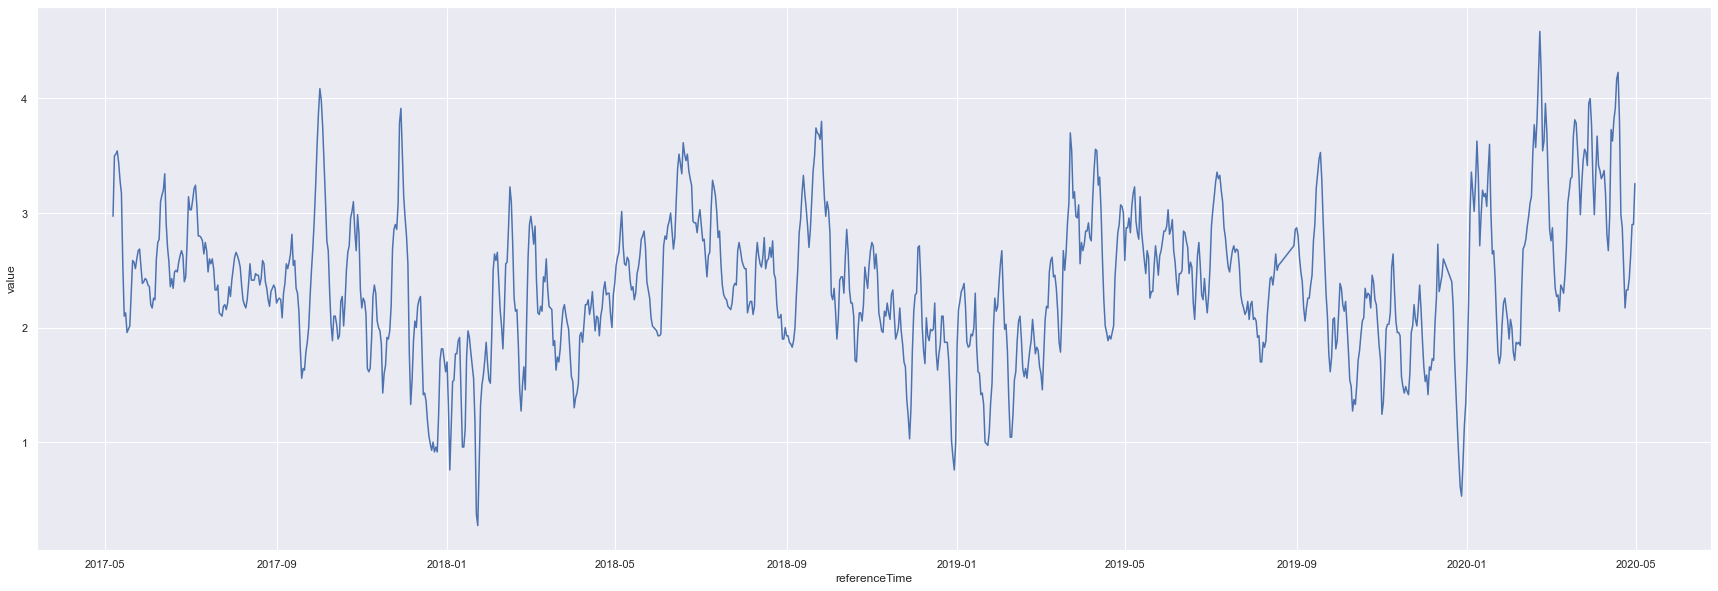

In [486]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

dfplot=df3.copy()
dfplot['value']=df3['value'].rolling(7).mean()

plt.figure(figsize=(30,10))
ax = sns.lineplot(x="referenceTime", y="value", data=dfplot)

Data retrieved from frost.met.no!


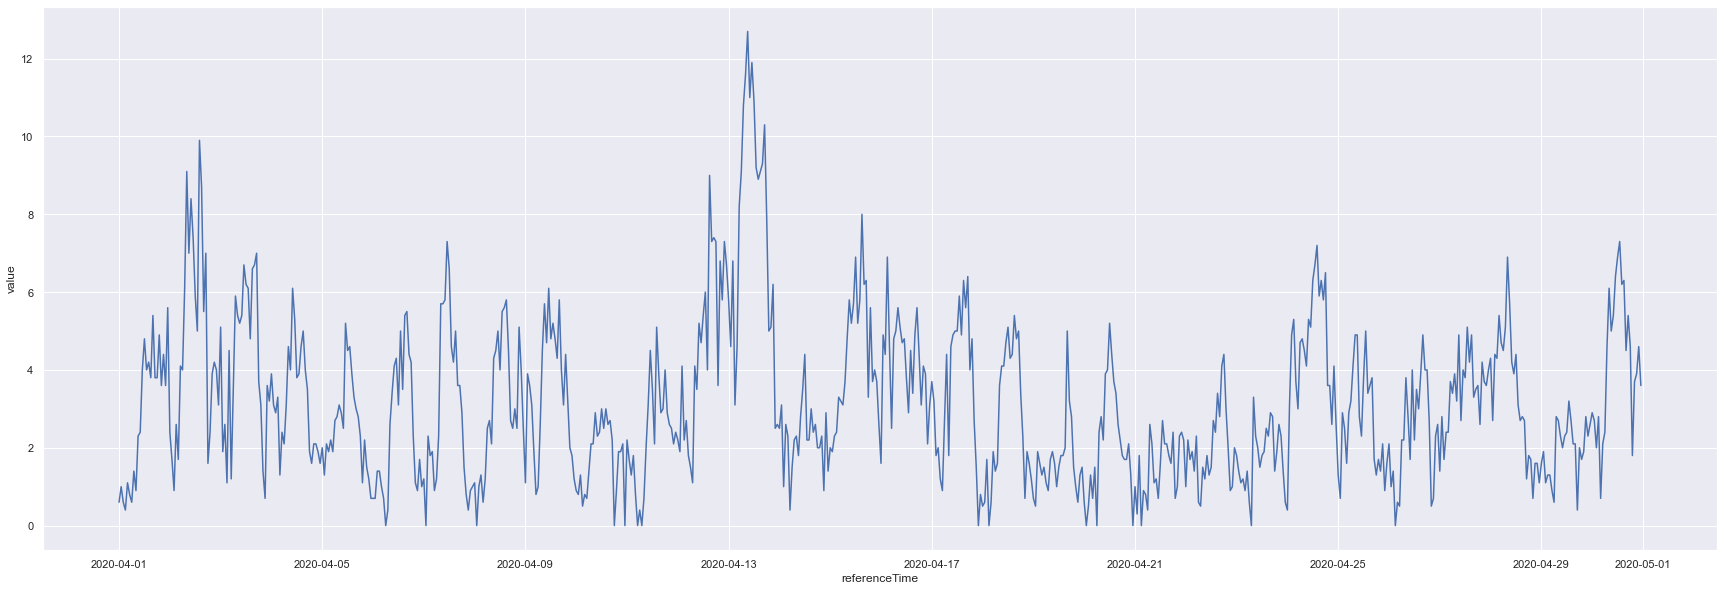

In [53]:
ws = graphelement(source='SN4200', elements= 'wind_speed',referencetime= '2020-04-01/2020-05-01',rollingmean=1)

In [ ]:
wws

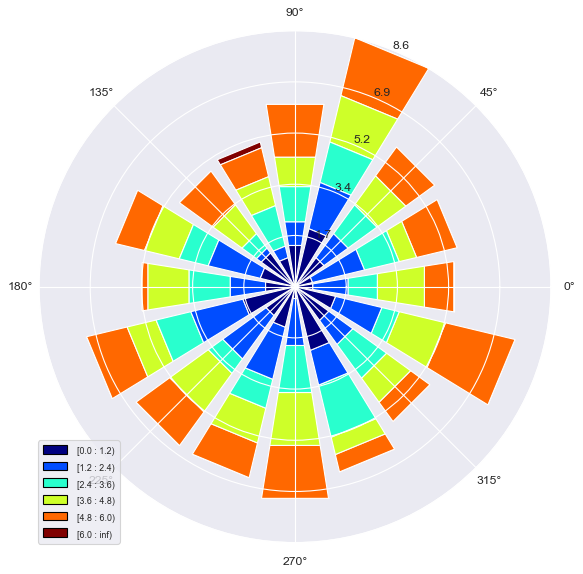

In [47]:
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Create wind speed and direction variables

ws = np.random.random(500) * 6
wd = np.random.random(500) * 360

ax = WindroseAxes.from_ax()
ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()